## Demo

### dependency setup

In [9]:
import os
import sys
sys.path.insert(0, f'../')

In [10]:
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

import clip

from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Contrastive Pair Setup

In [11]:
demo_pairs = [
    # white balance: DONE
    ["Accurate Color Representation", "Blue/Green Color Cast"],
    
    # vibrant and vivid: DONE
    ["Vibrant and vivid", "Dull and washed-out"],
    ["Bright, Colorful Underwater Scene", "Dim, Desaturated Underwater Colors"],

    # Exposure and lit: DONE
    ["Crystal-clear and Unobstructed Scene", "Murky and Obscured View"],
    ["Balanced and Well-Lit view", "Underlit scene and Backlit Objects"],
]

wb_indices = [0]
cl_indices = [1, 2]
exp_indices = [3, 4]

demo_pairs = np.ravel(demo_pairs)

### CLIP setup

In [12]:
from waternet.net import transform_
clip_img_preprocess = transform_()
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

def get_clip_score(img, calculate_scores=True):
    # img is path to image
    image = clip_preprocess(Image.open(img)).unsqueeze(0).to(device)
    
    text = clip.tokenize(demo_pairs).to(device)
    
    with torch.no_grad():
        logits_per_image, _ = clip_model(image, text)
        logits_per_image = logits_per_image.view(-1, 2)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        
        positive_scores = np.ravel(probs)[::2]
        
        if calculate_scores:
            wb_score = np.mean(positive_scores[wb_indices])
            cl_score = np.mean(positive_scores[cl_indices])
            exp_score = np.mean(positive_scores[exp_indices])
            return {
                "wb_score": wb_score,
                "cl_score": cl_score,
                "exp_score": exp_score,
            }
        else:
            return np.mean(positive_scores)

### WaterNet Setup

In [13]:
from waternet.net import WaterNet
from waternet.inference_utils import process

In [14]:
kinds = {
    "base": "weights/pretrained/waternet.pt",
    "vivid_mid": "weights/color-enhanced.pt",
    "color_cast": "weights/wb-enhanced.pt",
    "exposure": "weights/expo-enhanced.pt",
    "all0_last": "weights/all-enhanced.pt",
}

names = {
    "base": "Base",
    "vivid_mid": "Color Enhanced",
    "color_cast": "White Balance Enhanced",
    "exposure": "Exposure Enhanced",
    "all0_last": "All Enhanced",
}

waternets = []
for _, key in enumerate(kinds):
    waternet = WaterNet()
    check_point = torch.load(f'../{kinds[key]}', map_location=device)
    waternet.load_state_dict(check_point)
    waternet.eval()
    waternet = waternet.to(device)
    waternets.append(waternet)

In [15]:
def display_images(raw_path, _save_image=False):
    basename = os.path.basename(raw_path)
    raw = cv2.imread(raw_path)
    raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
    # raw = cv2.resize(raw, (640, 360))
    
    # Prepare the figure
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 6))
    axs = axs.flatten()  # Flatten the array for easy indexing

    # Display the source image
    axs[0].imshow(raw)
    axs[0].axis("off")
    axs[0].set_title("Source")
    scores = get_clip_score(raw_path, calculate_scores=True)
    axs[0].text(
            0.03,
            0.95,
            f"WB: {scores['wb_score']:.2f}\nCL: {scores['cl_score']:.2f}\nEXP: {scores['exp_score']:.2f}",
            horizontalalignment="left",
            verticalalignment="top",
            transform=axs[0].transAxes,
            fontsize=10,
            color="white",
            bbox=dict(facecolor="black", alpha=0.5, pad=5), 
        )
    
    offset = 1
    
    # Process and display each kind
    for index, kind in enumerate(kinds):
        img = process(raw, waternets[index])
        axs[index+offset].imshow(img)
        axs[index+offset].axis("off")
        axs[index+offset].set_title(names[kind], fontsize=10)

        path = f"./temp/"
        if not os.path.exists(path):
            os.makedirs(path)
            print(f"make dir path: {path}")
        output_image_path = f"{path}/{kind}_{basename}"
        cv2.imwrite(output_image_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        scores = get_clip_score(output_image_path, calculate_scores=True)
        axs[index+offset].text(
            0.03,
            0.95,
            f"WB: {scores['wb_score']:.2f}\nCL: {scores['cl_score']:.2f}\nEXP: {scores['exp_score']:.2f}",
            horizontalalignment="left",
            verticalalignment="top",
            transform=axs[index+offset].transAxes,
            fontsize=10,
            color="white",
            bbox=dict(facecolor="black", alpha=0.5, pad=5), 
        )
        
    plt.tight_layout()
    if _save_image:
        plt.savefig(f"./temp/demo_{basename}")
    plt.show()

### Playground

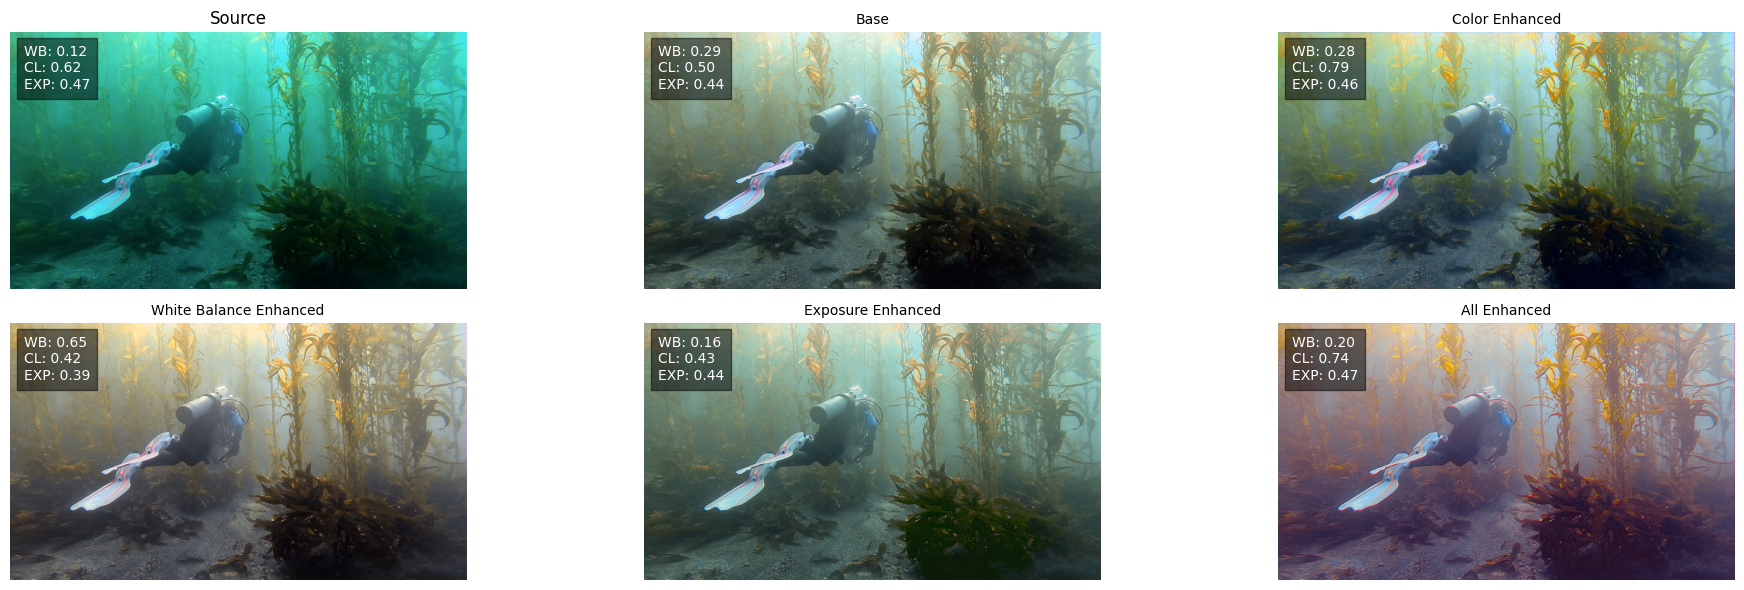

In [16]:
raw_path = "./outputs/raw_ScubaDiver.jpg"
display_images(raw_path, _save_image=True)